## Overview Performance of PhyloFormer on Viral Sequence Data

In this script I will test the performance of [Phyloformer (Nesterenko et al. "Phyloformer: towards fast and accurate phylogeny estimation with self-attention networks")](https://www.biorxiv.org/content/10.1101/2022.06.24.496975v1) on simulated influenza data. Typically influenza sequences HA and NA are around 1000 nucleotides long and have a resolution rate of approximately 0.35 which means that 65% of internal nodes are "missing" and polytomies exist in the tree. Generally, tree builders have issues with polytomies thus simulating data with such a feature is useful for assessing the performance of PhyloFormer. As a benchmark I will be comparing PhyloFormer with the standard [IQTree](http://www.iqtree.org/).

To do this I simulate trees of 8 recombining influenza segments with 100 leaves. 25% of leaves occur at sampling time 0, which is set at the date 2000 - the rest occur at earlier times. I use the flu coalescence model introduced by Pierre Barrat-Charlaix in [TreeKnit (Barrat-Charlaix et al. "TreeKnit: Inferring ancestral reassortment graphs of Influenza viruses")](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1010394) and use his simulation package [ARGTools](https://github.com/PierreBarrat/ARGTools). I then simulate mutations on each segment tree using a mutation rate of $$\mu = \frac{1.25}{N*c(r)*L},$$ where $N$ is the population size (set to 10000), $L$ is the sequence length (set to 1000) and $c(r)$ is an experimentally determined value which should correspond to the probability that there are no mutations on a branch and should result in trees with a desired resolution rate $r$. The sequences of all leaf nodes are written to a fasta file and the sequences are additionally dated, time 0 is set at the year 2000 and then times are set using the mutation rate of influenza which is 4.73e-3 per site per year.

I then use PhyloFormer and IQTree2 to infer trees from the fasta files and compare the [robinson-fold distance](https://en.wikipedia.org/wiki/Robinson%E2%80%93Foulds_metric) of the inferred trees to the true trees and also the unresolved trees (internal branches are removed if no mutations occur on them and thus cannot be inferred from sequence information alone). Prior to this step I need to translate the nucleotide sequences into amino acid sequences for Phyloformer as it has not been trained on nucleotide data. 

#### 1. Simulation

The simulation scripts are written in julia and precompiled and then called by in bash using a python wrapper. 

In [28]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Data import CodonTable

def get_aa_seq(input_file, output_file):
    '''
    Function to convert nucleotide sequence to amino acid sequence 
    (as some nucleotide triplets do not correspond to amino acids this is seen as missing information)
    '''
    aa_dict = CodonTable.standard_dna_table.forward_table
    aa_stop_dict = CodonTable.standard_dna_table.stop_codons

    i = 0
    records = list(SeqIO.parse(input_file, "fasta"))
    with open(output_file, "w") as output_handle:
        while i < len(records):
            nuc = records[i].seq
            amino_acids = [] 
            for j in range(0, len(nuc), 3):
                if nuc[j:j+3] in aa_dict:
                    amino_acids.append(aa_dict[nuc[j:j+3]])
                elif nuc[j:j+3] in aa_stop_dict:
                    amino_acids.append('*')
                else:
                    amino_acids.append('-')
            aa = Seq("".join(amino_acids))
            records[i].seq = aa
            SeqIO.write(records[i], output_handle, "fasta")
            i +=1

In [29]:
from augur.io import run_shell_command, shquote

sim = 10
n_leaves = 50 # number of leaves
s = 0.5 #rate of adding back leaves (0.5 = leaves are added back at 0.5*rate of coalescence) - this effects time of sampling
res = 0.4 #desired resolution of tree 

def simulate(n_leaves, s, res, sim):
    dir = "input"
    for n in range(1, sim):
        cmd = "julia --project=TreeSimulations/. -J TreeSimulations/tree_simulations.so TreeSimulations/PhyloFormerSimulations.jl --n "+ str(n_leaves)+ " --o "+ dir + str(n) + " --s "+ str(s)+" --res " + str(res)
        run_shell_command(cmd, raise_errors = True)
        run_shell_command("mkdir " +dir+ str(n)+"/aa", raise_errors = True)
        for i in range(1,9):
            get_aa_seq(dir+str(n)+"/"+str(i)+".fasta", dir+str(n)+"/aa/aa_"+str(i)+".fasta")

simulate(n_leaves, s, res, sim)
    

#### 2. Inference
Now run IQtree and PhyloFormer on all trees and calculate the RF distance.

In [30]:
import os
import numpy as np
from ete3 import Tree
from Bio import Phylo

def infer_trees(sim, n_leaves, s, res, remove=True):
    RF_iqtree = []
    RF_phyloformer = []
    RF_iqtree_unresolved = []
    RF_phyloformer_unresolved = []
    resolution_rate = []

    dir = "input"
    for n in range(1, sim):
        #run phyloformer
        run_shell_command("mkdir results" + str(n), raise_errors = True)
        cmd = "python PhyloFormer_predict " + dir + str(n) + "/aa --o results" + str(n) 
        run_shell_command(cmd, raise_errors = True)
        for i in range(1,9):

            #run IQtree on each alignment
            tmp_aln_file = dir+str(n)+"/" + str(i) + ".fasta"
            log_file = "log.txt"
            call = ["iqtree -s", shquote(tmp_aln_file), "--date TAXNAME -ninit 10 -n 4 -czb -redo", ">", log_file]
            cmd = " ".join(call)
            run_shell_command(cmd, raise_errors = True)

            #get true resolution rate
            true_tree=Phylo.read(dir+str(n)+"/true_" + str(i) + ".nwk", "newick")
            unresolved_tree=Phylo.read(dir+str(n)+"/" + str(i) + ".nwk", "newick")
            resolution_rate.append(len(unresolved_tree.get_nonterminals())/ n_leaves)

            #get RF distance
            true_tree=Tree(dir+str(n)+"/true_" + str(i) + ".nwk", format=1)
            unresolved_tree=Tree(dir+str(n)+"/" + str(i) + ".nwk", format=1)
            phyloformer_tree=Tree('results'+ str(n) + '/predicted_aa_'+str(i)+'.nwk')
            leaves = phyloformer_tree.get_leaves()
            for leaf in leaves:
                leaf.name = leaf.name.split("|")[0]
            RF_phyloformer_unresolved.append(unresolved_tree.compare(phyloformer_tree,unrooted=True)['norm_rf'])
            RF_phyloformer.append(true_tree.compare(phyloformer_tree,unrooted=True)['norm_rf'])

            iq_tree=Tree(dir+str(n)+"/" + str(i) +'.fasta.treefile')
            leaves = iq_tree.get_leaves()
            for leaf in leaves:
                leaf.name = leaf.name.split("|")[0]
            RF_iqtree_unresolved.append(unresolved_tree.compare(iq_tree,unrooted=True)['norm_rf'])
            RF_iqtree.append(true_tree.compare(iq_tree,unrooted=True)['norm_rf'])
        if remove:
            run_shell_command("rm -r results" + str(n), raise_errors = True)
            run_shell_command("rm -r " + dir + str(n), raise_errors = True)
    return RF_iqtree, RF_phyloformer, RF_iqtree_unresolved, RF_phyloformer_unresolved, resolution_rate
    
RF_iqtree, RF_phyloformer, RF_iqtree_unresolved, RF_phyloformer_unresolved, resolution_rate =  infer_trees(sim, n_leaves, s, res, remove=True)

In [31]:

print(f'Mean normalized Robinson-Foulds distance between true and predicted flu trees - phyloformer: {np.mean(RF_phyloformer):.3f}')

print(f'Mean normalized Robinson-Foulds distance between true and predicted flu trees - iqtree: {np.mean(RF_iqtree):.3f}')

print(f'Mean normalized Robinson-Foulds distance between unresolved and predicted flu trees - phyloformer: {np.mean(RF_phyloformer_unresolved):.3f}')

print(f'Mean normalized Robinson-Foulds distance between unresolved and predicted flu trees - iqtree: {np.mean(RF_iqtree_unresolved):.3f}')



Mean normalized Robinson-Foulds distance between true and predicted flu trees - phyloformer: 0.975
Mean normalized Robinson-Foulds distance between true and predicted flu trees - iqtree: 0.458
Mean normalized Robinson-Foulds distance between unresolved and predicted flu trees - phyloformer: 0.972
Mean normalized Robinson-Foulds distance between unresolved and predicted flu trees - iqtree: 0.186


Making the resolution rate higher leads to better performance of IQtree but in both cases PhyloFormer performs quite badly on poorly resolved influenza data. My guess is this is due to multiple factors, first and foremost the model not being trained on nucleotide data, it being trained only on small trees and additionally, in my understanding it has not been trained on poorly resolved or even trees with leaves of varying sampling time points.

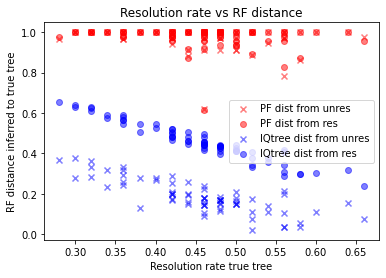

In [45]:
import matplotlib.pyplot as plt

plt.scatter(resolution_rate, RF_phyloformer_unresolved, label="PF dist from unres", color="red", marker="x", alpha=0.5)
plt.scatter(resolution_rate, RF_phyloformer, label="PF dist from res", color="red", marker="o", alpha=0.5)
plt.scatter(resolution_rate, RF_iqtree_unresolved, label="IQtree dist from unres", color="blue", marker="x", alpha=0.5)
plt.scatter(resolution_rate, RF_iqtree, label="IQtree dist from res", color="blue", marker="o", alpha=0.5)
plt.title("Resolution rate vs RF distance")
plt.xlabel("Resolution rate true tree")
plt.ylabel("RF distance inferred to true tree")
plt.legend()